# 图层叠加展示 (Overlay Display)

本 Notebook 用于：

- 将基础底图（阴影 / DEM）与地质图层叠加。
- 调整样式（颜色、线宽、透明度、顺序）以生成用于展示的整合地图。

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import rioxarray as rxr, geopandas as gpd
import numpy as np
from pyproj import CRS, Transformer

In [2]:
tif_path = Path('../resources/SIM3292_MarsGlobalGeologicGIS_20M/Basemaps/MOLA_Hillshade_Robinson_128ppd.tif')
shp_path = Path('../resources/SIM3292_MarsGlobalGeologicGIS_20M/SIM3292_Shapefiles/SIM3292_Global_Geology.shp')
title = 'Geology'
save_path = '../output/images/geology.png'

downsample_factor = 32 # 降采倍率 (宽高同时 / 该因子); 建议 16~64 之间根据性能选择

show_graticule = True  # 是否显示经纬网

In [3]:
# 地质单元颜色映射
color_map = {
    'AHi': '#ffff00',    # Amazonian and Hesperian impact unit
    'AHtu': '#faead6',   # Amazonian and Hesperian transition undivided unit
    'AHv': '#cd4e37',    # Amazonian and Hesperian volcanic
    'ANa': '#ccad00',    # Amazonian and Noachian apron unit
    'Aa': '#ffd900',     # Amazonian apron unit
    'Ap': '#00e8f0',     # Amazonian polar unit
    'Apu': '#0000cc',    # Amazonian polar undivided unit
    'Av': '#ff6347',     # Amazonian volcanic unit
    'Ave': '#cc3600',    # Amazonian volcanic edifice
    'HNb': '#698c69',    # Hesperian and Noachian basin unit
    'HNhu': '#b2b2b2',   # Hesperian and Noachian highland undivided unit
    'HNt': '#cdbd70',    # Hesperian and Noachian transition unit
    'Hp': '#00858a',     # Hesperian polar unit
    'Hpe': '#6ba5cc',    # Hesperian polar edifice unit
    'Hpu': '#9ab2e6',    # Hesperian polar undivided unit
    'Ht': '#ffeb8a',     # Hesperian transition unit
    'Hto': '#bdffff',    # Hesperian transition outflow unit
    'Htu': '#cccccc',    # Hesperian transition undivided unit
    'Hve': '#ff0000',    # Hesperian volcanic edifice unit
    'Nhe': '#730000',    # Noachian highland edifice unit
    'Nhu': '#686868',    # Noachian highland undivided unit
    'Nve': '#cc0000',    # Noachian volcanic edifice unit
    'eAb': '#99ffff',    # Early Amazonian basin unit
    'eHb': '#9dcd9d',    # Early Hesperian basin unit
    'eHh': '#efd5b8',    # Early Hesperian highland unit
    'eHt': '#cf980c',    # Early Hesperian transition unit
    'eHv': '#8a668a',    # Early Hesperian volcanic unit
    'eNh': '#8b4513',    # Early Noachian highland unit
    'eNhm': '#848b8b',   # Early Noachian highland massif unit
    'lAa': '#8a7500',    # Late Amazonian apron unit
    'lApc': '#f5f5f5',   # Late Amazonian polar cap unit
    'lApd': '#ffe3b3',   # Late Amazonian polar dunes unit
    'lAv': '#ffb8c1',    # Late Amazonian volcanic unit
    'lAvf': '#b39999',   # Late Amazonian volcanic field unit
    'lHb': '#518a8a',    # Late Hesperian basin unit
    'lHl': '#228c22',    # Late Hesperian lowland unit
    'lHt': '#ffc124',    # Late Hesperian transition unit
    'lHv': '#cd6aca',    # Late Hesperian volcanic unit
    'lHvf': '#ccb3b3',   # Late Hesperian volcanic field unit
    'lNh': '#cdab7e',    # Late Noachian highland unit
    'lNv': '#531a89',    # Late Noachian volcanic unit
    'mAl': '#6a8c22',    # Middle Amazonian lowland unit
    'mNh': '#8b7355',    # Middle Noachian highland unit
    'mNhm': '#c1cdcd'    # Middle Noachian highland massif unit
}

In [4]:
print('Raster exists:', tif_path.exists(), '| Shapefile exists:', shp_path.exists())

Raster exists: True | Shapefile exists: True


In [5]:
# 读取basemap数据

# 加载为 rioxarray 数据
da = rxr.open_rasterio(tif_path, masked=True).squeeze()
print('Raster CRS via rioxarray:', da.rio.crs)


# 使用 xarray coarsen 进一步平滑
coarse = da.coarsen(x=downsample_factor, y=downsample_factor, boundary='trim').mean()

# 创建mask来隐藏无效值和边界（通常黑色区域的值很低或为0）
mask = (coarse > coarse.quantile(0.05)) & ~np.isnan(coarse)
# 使用where来只显示有效数据，无效区域设为透明
coarse_masked = coarse.where(mask)

Raster CRS via rioxarray: PROJCS["Robinson_clon0_Mars_2000_Sphere",GEOGCS["GCS_Mars_2000_Sphere",DATUM["<custom>",SPHEROID["<custom>",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [6]:
# 读取shapefile数据

gdf = None
if shp_path.exists():
    gdf = gpd.read_file(shp_path)
    print('Vector count:', len(gdf), '| Vector CRS:', gdf.crs)
    # 简要列出字段
    print('Columns:', list(gdf.columns)[:10])
else:
    print('Shapefile not found; overlay will be skipped.')

Vector count: 1311 | Vector CRS: GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0],AUTHORITY["ESRI","106971"]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Columns: ['OBJECTID', 'Shape_Leng', 'Shape_Area', 'Unit', 'UnitDesc', 'SphArea_km', 'geometry']


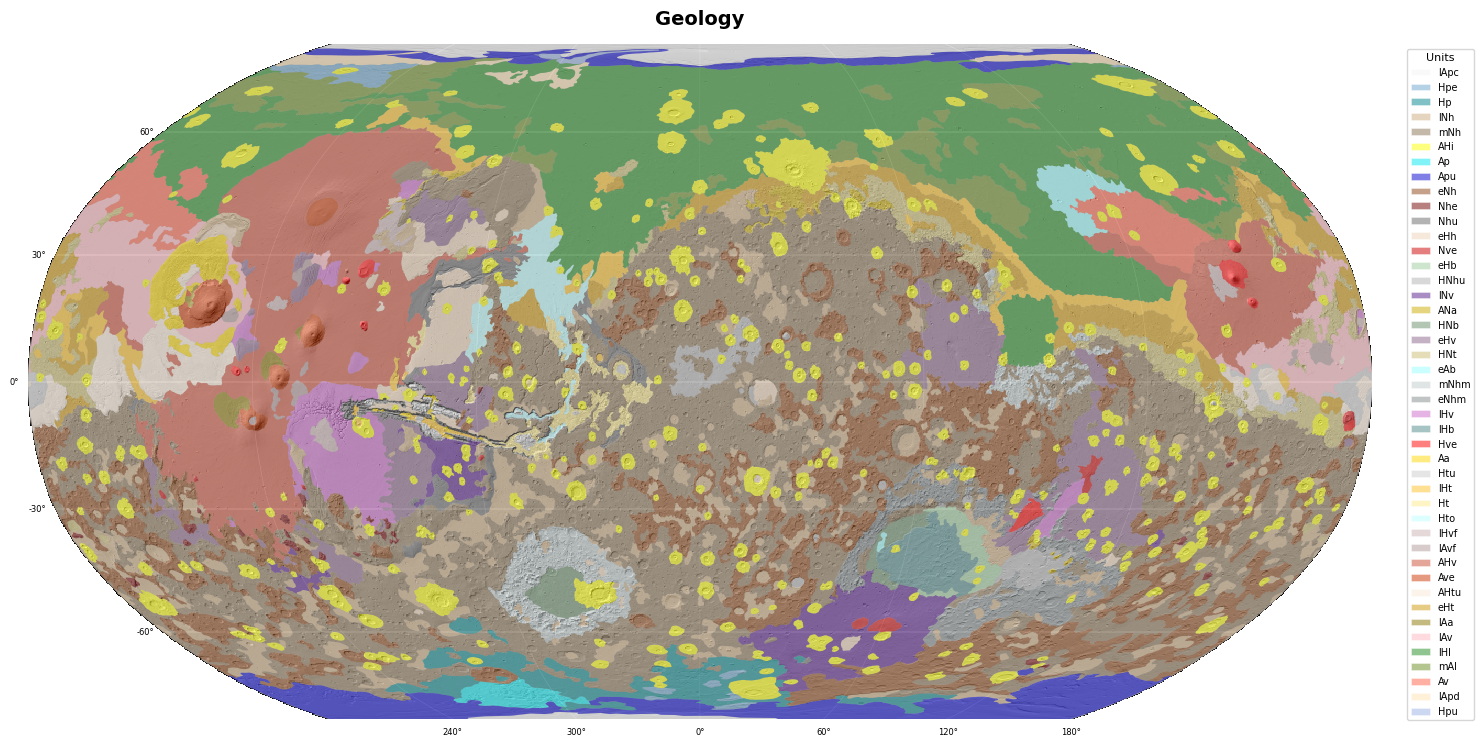

In [7]:
fig, ax = plt.subplots(figsize=(16,8))

# 底图
coarse_masked.plot(ax=ax, cmap='gray', add_colorbar=False, zorder=0)

# 矢量叠加
if 'gdf' in globals() and gdf is not None and len(gdf):
    target_crs = da.rio.crs
    if gdf.crs != target_crs:
        try:
            gdf_prj = gdf.to_crs(target_crs)
        except Exception as e:
            print('矢量重投影失败，使用原始:', e)
            gdf_prj = gdf
    else:
        gdf_prj = gdf
    
    # 根据Unit字段分配颜色
    if 'Unit' in gdf_prj.columns:        
        # 使用预定义的颜色映射，对于未定义的单元使用黑色
        polygon_colors = []
        for unit in gdf_prj['Unit']:
            if unit in color_map:
                polygon_colors.append(color_map[unit])
            else:
                polygon_colors.append('#000000')  # 黑色作为默认颜色
                print(f'警告: 未找到单元 {unit} 的颜色定义，使用默认黑色')
        
        # 绘制多边形，设置半透明
        gdf_prj.plot(ax=ax, 
                    color=polygon_colors, 
                    alpha=0.5,
                    edgecolor='white', 
                    linewidth=0.01, 
                    zorder=3)
        
        # 创建图例        
        legend_elements = []
        for unit in gdf_prj['Unit'].unique():
            unit_color = color_map.get(unit, '#000000')
            legend_elements.append(plt.Rectangle((0,0),1,1, 
                               facecolor=unit_color, 
                               alpha=0.5, 
                               edgecolor='white', 
                               linewidth=0.5,
                               label=f'{unit}'))
        
        ax.legend(handles=legend_elements, 
             loc='upper right', 
             bbox_to_anchor=(1.08, 1),
             fontsize=7,
             title='Units',
             title_fontsize=8,
             ncol=1)
        
    else:
        print('未找到Unit字段，使用默认红色边框')
        gdf_prj.plot(ax=ax, color='none', edgecolor='red', linewidth=0.8, zorder=3)
else:
    print('No vector data to plot (gdf is None or empty).')

# 经纬网函数
def add_graticule(ax, target_crs):
    try:
        crs_obj = CRS.from_user_input(target_crs)
        geodetic_crs = crs_obj.geodetic_crs
    except Exception as e:
        print('投影解析失败，跳过经纬网:', e)
        return
    transformer = Transformer.from_crs(geodetic_crs, crs_obj, always_xy=True)

    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    xspan = xmax - xmin; yspan = ymax - ymin

    # 经线 (每60度)
    meridian_data = {}
    for lon in range(0, 360, 60):
        lats = np.linspace(-90, 90, 721)
        lons = np.full_like(lats, lon, dtype=float)
        xs, ys = transformer.transform(lons, lats)
        ax.plot(xs, ys, color='white', lw=0.35, alpha=0.5, zorder=1)
        meridian_data[lon] = (xs, ys)

    # 纬线 (每30度)
    parallel_data = {}
    for lat in range(-90, 91, 30):
        lons = np.linspace(0, 360, 721)
        lats = np.full_like(lons, lat, dtype=float)
        xs, ys = transformer.transform(lons, lats)
        ax.plot(xs, ys, color='white', lw=0.35, alpha=0.5, zorder=1)
        parallel_data[lat] = (xs, ys)

    # 标注经度 (底边)
    for lon, (xs, ys) in meridian_data.items():
        idx = np.argmin(np.abs(ys - ymin))
        x_lab, y_line = xs[idx], ys[idx]
        if xmin <= x_lab <= xmax:
            ax.text(x_lab, ymin - 0.012 * yspan, f'{lon}°', ha='center', va='top',
                    fontsize=6, color='black', alpha=1, zorder=5)

    # 标注纬度 (左边)
    for lat, (xs, ys) in parallel_data.items():
        mask_visible = (ys >= ymin) & (ys <= ymax)
        if not mask_visible.any():
            continue
        xs_vis = xs[mask_visible]; ys_vis = ys[mask_visible]
        idx_left = np.argmin(xs_vis)
        x_left = xs_vis[idx_left]; y_left = ys_vis[idx_left]
        ax.text(x_left - 0.008 * xspan, y_left, f'{lat}°', ha='right', va='center',
                fontsize=6, color='black', alpha=1, zorder=5)

if show_graticule:
    add_graticule(ax, da.rio.crs)

# 标题与外观
ax.set_title(title, fontsize=14, fontweight='bold', pad=14)
ax.set_axis_off()
plt.tight_layout()
if save_path:
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()